In [ ]:
# Instalación de dependencias
# pip install -r requirements.txt

# Importar librerías necesarias
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configurar visualización
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("📦 Librerías importadas correctamente")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

In [11]:
# Importar nuestro extractor de SICOSS
from SicossDataExtractor import *

print("🚀 SicossDataExtractor importado correctamente")

# Configuración para pruebas con diferentes límites de legajos
LIMITES_PRUEBA = {
    'mini': 10,      # Prueba rápida
    'pequeno': 50,   # Prueba pequeña
    'mediano': 200,  # Prueba mediana
    'grande': 1000,  # Prueba grande
    'xl': 5000,       # Prueba extra grande
    'xxl': 10000,     # Prueba extra extra grande
}

# Configuración SICOSS para pruebas
config_sicoss = SicossConfig(
    tope_jubilatorio_patronal=3245240.49,
    tope_jubilatorio_personal=3245240.49,
    tope_otros_aportes_personales=99000000,
    trunca_tope=True,
    check_lic=False,
    check_retro=False,
    asignacion_familiar=False
)

print("✅ Configuración SICOSS creada")
print(f"   Tope jubilatorio patronal: ${config_sicoss.tope_jubilatorio_patronal:,.0f}")
print(f"   Tope SAC patronal: ${config_sicoss.tope_sac_jubilatorio_patr:,.0f}")


🚀 SicossDataExtractor importado correctamente
✅ Configuración SICOSS creada
   Tope jubilatorio patronal: $3,245,240
   Tope SAC patronal: $1,622,620


In [ ]:
# Configurar conexión a base de datos
# NOTA: Asegúrate de tener el archivo database.ini configurado

def conectar_base_datos():
    """Establece conexión con la base de datos"""
    try:
        db = DatabaseConnection('database.ini')
        print("✅ Conexión a base de datos exitosa")
        return db
    except Exception as e:
        print(f"❌ Error conectando a base de datos: {e}")
        print("💡 Verifica que database.ini esté configurado correctamente")
        return None

# Probar conexión
db_connection = conectar_base_datos()

if db_connection:
    # Probar una consulta simple
    try:
        test_query = "SELECT COUNT(*) as total_legajos FROM mapuche.dh01 WHERE tipo_estad = 'A'"
        result = db_connection.execute_query(test_query)
        total_legajos = result.iloc[0]['total_legajos']
        print(f"📊 Total de legajos activos en la base: {total_legajos:,}")
        
        if total_legajos > 30000:
            print("⚠️ Base de datos grande detectada - usaremos límites para las pruebas")
        
    except Exception as e:
        print(f"⚠️ Error consultando total de legajos: {e}")
        print("🔄 Continuaremos con las pruebas limitadas")


In [ ]:
def extraer_muestra_legajos(db, limite=100, periodo_ano=2025, periodo_mes=5):
    """
    Extrae una muestra limitada de legajos para pruebas usando la consulta EXACTA del PHP
    Basada en SicossOptimizado.php -> get_sql_legajos()
    """
    print(f"🔍 Extrayendo muestra de {limite} legajos usando consulta REAL del PHP")
    print(f"   📅 Período: {periodo_ano}/{periodo_mes}")
    print(f"   🏢 Reparto: REPA")
    
    # Consulta EXACTA copiada del PHP SicossOptimizado.php -> get_sql_legajos()
    # Parámetros: $tabla = mapuche.dh01, $valor = 0, $where = true
    query_muestra = f"""
    SELECT
        DISTINCT(dh01.nro_legaj),
        (dh01.nro_cuil1::char(2)||LPAD(dh01.nro_cuil::char(8),8,'0')||dh01.nro_cuil2::char(1))::float8 AS cuit,
        dh01.desc_appat||' '||dh01.desc_nombr AS apyno,
        dh01.tipo_estad AS estado,
        
        -- Optimización: reemplazar subconsultas con JOIN agregado
        COALESCE(familiares.conyugue, 0) AS conyugue,
        COALESCE(familiares.hijos, 0) AS hijos,
        
        dha8.ProvinciaLocalidad,
        dha8.codigosituacion,
        dha8.CodigoCondicion,
        dha8.codigozona,
        dha8.CodigoActividad,
        dha8.porcaporteadicss AS aporteAdicional,
        dha8.trabajador_convencionado AS trabajadorconvencionado,
        dha8.codigomodalcontrat AS codigocontratacion,
        
        CASE WHEN ((dh09.codc_bprev = 'REPA') OR (dh09.fuerza_reparto) OR (('REPA' = '') AND (dh09.codc_bprev IS NULL)))
             THEN '1' ELSE '0' END AS regimen,
        
        dh09.cant_cargo AS adherentes,
        0 AS licencia,
        0 AS importeimponible_9

    FROM mapuche.dh01
    
    -- JOIN optimizado para contar familiares una sola vez
    LEFT JOIN (
        SELECT 
            nro_legaj,
            COUNT(CASE WHEN codc_paren = 'CONY' THEN 1 END) AS conyugue,
            COUNT(CASE WHEN codc_paren IN ('HIJO', 'HIJN', 'HINC', 'HINN') THEN 1 END) AS hijos
        FROM mapuche.dh02 
        WHERE sino_cargo != 'N'
        GROUP BY nro_legaj
    ) familiares ON familiares.nro_legaj = mapuche.dh01.nro_legaj

    LEFT OUTER JOIN mapuche.dha8 ON dha8.nro_legajo = mapuche.dh01.nro_legaj
    LEFT OUTER JOIN mapuche.dh09 ON dh09.nro_legaj = mapuche.dh01.nro_legaj
    LEFT OUTER JOIN mapuche.dhe9 ON dhe9.nro_legaj = mapuche.dh01.nro_legaj
    
    WHERE true
    LIMIT {limite}
    """
    
    try:
        df_muestra = db.execute_query(query_muestra)
        legajos_muestra = df_muestra['nro_legaj'].tolist()
        print(f"✅ Muestra extraída: {len(legajos_muestra)} legajos con estructura completa del PHP")
        print(f"   📊 Campos extraídos: {len(df_muestra.columns)} columnas (idénticas al PHP)")
        
        # Mostrar algunos campos clave para verificar
        if not df_muestra.empty:
            print(f"   👥 Rango legajos: {df_muestra['nro_legaj'].min()} - {df_muestra['nro_legaj'].max()}")
            print(f"   💑 Con cónyuge: {df_muestra['conyugue'].sum()}")
            print(f"   👶 Con hijos: {df_muestra['hijos'].sum()}")
        
        return legajos_muestra, df_muestra  # Retornamos también el DataFrame completo
    except Exception as e:
        print(f"❌ Error extrayendo muestra: {e}")
        return [], pd.DataFrame()

def ejecutar_prueba_sicoss(db, limite_legajos, nombre_prueba="prueba"):
    """
    Ejecuta una prueba completa del extractor SICOSS con límite de legajos
    Usa parámetros EXACTOS del PHP: per_anoct=2025, per_mesct=5, sino_genimp=TRUE
    """
    print(f"\n{'='*60}")
    print(f"🚀 INICIANDO PRUEBA: {nombre_prueba.upper()}")
    print(f"📊 Límite de legajos: {limite_legajos}")
    print(f"📅 Parámetros PHP: per_anoct=2025, per_mesct=5")
    print(f"{'='*60}")
    
    # Obtener muestra de legajos (ahora retorna tupla)
    legajos_muestra, df_muestra_completa = extraer_muestra_legajos(db, limite_legajos, 2025, 5)
    
    if not legajos_muestra:
        print("❌ No se pudieron obtener legajos para la prueba")
        return None
    
    # Crear filtro WHERE para la muestra
    legajos_str = ','.join(map(str, legajos_muestra))
    where_legajo = f"dh01.nro_legaj IN ({legajos_str})"
    
    # Inicializar extractor y procesador con parámetros exactos del PHP
    extractor = SicossDataExtractor(db)
    procesador = SicossDataProcessor(config_sicoss)
    
    # FASE 1: EXTRACCIÓN DE DATOS (con parámetros exactos del PHP)
    print("\n📥 FASE 1: EXTRACCIÓN DE DATOS")
    inicio_extraccion = time.time()
    
    try:
        # Extraer legajos usando consulta exacta del PHP
        print("   📋 Extrayendo legajos con consulta PHP...")
        df_legajos = extractor._extraer_legajos(2025, 5, where_legajo)
        
        # Extraer conceptos liquidados con parámetros exactos del PHP
        print("   💰 Extrayendo conceptos liquidados...")
        print("       └─ per_anoct=2025, per_mesct=5, sino_genimp=TRUE, codn_conce>0")
        where_conceptos = f"dh21.nro_legaj IN ({legajos_str})"
        df_conceptos = extractor._extraer_conceptos_liquidados(2025, 5, where_conceptos)
        
        # Extraer otra actividad
        print("   🏢 Extrayendo otra actividad...")
        df_otra_actividad = extractor._extraer_otra_actividad(legajos_muestra)
        
        # Extraer obra social
        print("   🏥 Extrayendo obra social...")
        df_obra_social = extractor._extraer_codigos_obra_social(legajos_muestra)
        
        tiempo_extraccion = time.time() - inicio_extraccion
        
        # Mostrar estadísticas de extracción con datos exactos del PHP
        print(f"\n   📊 ESTADÍSTICAS DE EXTRACCIÓN (datos exactos del PHP):")
        print(f"       ├─ Legajos: {len(df_legajos)} registros, {len(df_legajos.columns)} campos")
        print(f"       ├─ Conceptos: {len(df_conceptos)} registros, {len(df_conceptos.columns)} campos")
        print(f"       ├─ Otra actividad: {len(df_otra_actividad)} registros")
        print(f"       └─ Obra social: {len(df_obra_social)} registros")
        
        # Datos extraídos
        datos_extraidos = {
            'legajos': df_legajos,
            'conceptos': df_conceptos,
            'otra_actividad': df_otra_actividad,
            'obra_social': df_obra_social
        }
        
        print(f"✅ Extracción completada en {tiempo_extraccion:.2f}s")
        
    except Exception as e:
        print(f"❌ Error en extracción: {e}")
        return None
    
    # FASE 2: PROCESAMIENTO
    print("\n🔧 FASE 2: PROCESAMIENTO DE DATOS")
    inicio_procesamiento = time.time()
    
    try:
        resultado = procesador.procesar_datos_extraidos(datos_extraidos)
        tiempo_procesamiento = time.time() - inicio_procesamiento
        print(f"✅ Procesamiento completado en {tiempo_procesamiento:.2f}s")
        
    except Exception as e:
        print(f"❌ Error en procesamiento: {e}")
        return None
    
    # FASE 3: RESULTADOS
    print("\n📊 FASE 3: RESULTADOS")
    
    tiempo_total = tiempo_extraccion + tiempo_procesamiento
    
    # Estadísticas de rendimiento
    stats = resultado['estadisticas']
    print(f"⏱️  TIEMPOS:")
    print(f"   Extracción: {tiempo_extraccion:.2f}s")
    print(f"   Procesamiento: {tiempo_procesamiento:.2f}s")
    print(f"   Total: {tiempo_total:.2f}s")
    print(f"   Rendimiento: {stats['total_legajos']/tiempo_total:.1f} legajos/segundo")
    
    print(f"\n📈 ESTADÍSTICAS:")
    print(f"   Total legajos: {stats['total_legajos']}")
    print(f"   Legajos válidos: {stats['legajos_validos']}")
    print(f"   Legajos rechazados: {stats['legajos_rechazados']}")
    print(f"   Tasa de éxito: {(stats['legajos_validos']/stats['total_legajos']*100) if stats['total_legajos'] > 0 else 0:.1f}%")
    
    # Estadísticas de datos
    print(f"\n📊 DATOS EXTRAÍDOS:")
    for nombre, df in datos_extraidos.items():
        print(f"   {nombre.capitalize()}: {len(df):,} registros")
    
    if not df_conceptos.empty:
        conceptos_por_legajo = df_conceptos.groupby('nro_legaj').size()
        print(f"   Promedio conceptos/legajo: {conceptos_por_legajo.mean():.1f}")
    
    # Totales financieros
    if stats['legajos_validos'] > 0:
        totales = resultado['totales']
        print(f"\n💰 TOTALES FINANCIEROS:")
        for concepto, valor in totales.items():
            if valor > 0:
                print(f"   {concepto}: ${valor:,.2f}")
    
    # Retornar resultados para análisis posterior
    return {
        'nombre_prueba': nombre_prueba,
        'limite_legajos': limite_legajos,
        'tiempo_extraccion': tiempo_extraccion,
        'tiempo_procesamiento': tiempo_procesamiento,
        'tiempo_total': tiempo_total,
        'estadisticas': stats,
        'totales': resultado['totales'],
        'datos_extraidos': datos_extraidos,
        'legajos_procesados': resultado['legajos_procesados']
    }

print("✅ Funciones de prueba definidas correctamente")


In [ ]:
# 🧪 EJECUTAR PRUEBA RÁPIDA (10 legajos)
# Ideal para verificar que todo funciona correctamente

if db_connection:
    resultado_mini = ejecutar_prueba_sicoss(
        db=db_connection, 
        limite_legajos=LIMITES_PRUEBA['mini'], 
        nombre_prueba="mini"
    )
    
    if resultado_mini:
        print(f"\n🎉 ¡Prueba mini completada exitosamente!")
        print(f"   Procesados {resultado_mini['estadisticas']['legajos_validos']} legajos")
        print(f"   Tiempo total: {resultado_mini['tiempo_total']:.2f}s")
else:
    print("❌ No hay conexión a la base de datos")


In [ ]:
# 📊 ANÁLISIS DE DATOS EXTRAÍDOS
# Explorar los DataFrames resultantes de la prueba mini

if 'resultado_mini' in locals() and resultado_mini:
    datos = resultado_mini['datos_extraidos']
    
    print("🔍 ANÁLISIS DE DATOS EXTRAÍDOS")
    print("=" * 40)
    
    # Análisis del DataFrame de legajos
    df_legajos = datos['legajos']
    if not df_legajos.empty:
        print(f"\n📋 LEGAJOS ({len(df_legajos)} registros):")
        print(f"   Columnas: {list(df_legajos.columns)}")
        print(f"   Tipos de estado: {df_legajos['estado'].value_counts().to_dict()}")
        if 'codigosituacion' in df_legajos.columns:
            print(f"   Códigos situación: {df_legajos['codigosituacion'].value_counts().head().to_dict()}")
        
        # Mostrar muestra de legajos
        print(f"\n   Muestra de legajos:")
        display(df_legajos[['nro_legaj', 'apyno', 'cuit', 'estado']].head())
    
    # Análisis del DataFrame de conceptos
    df_conceptos = datos['conceptos']
    if not df_conceptos.empty:
        print(f"\n💰 CONCEPTOS ({len(df_conceptos)} registros):")
        conceptos_por_legajo = df_conceptos.groupby('nro_legaj').size()
        print(f"   Promedio conceptos por legajo: {conceptos_por_legajo.mean():.1f}")
        print(f"   Máximo conceptos por legajo: {conceptos_por_legajo.max()}")
        print(f"   Mínimo conceptos por legajo: {conceptos_por_legajo.min()}")
        
        # Top conceptos por importe
        top_conceptos = df_conceptos.groupby('codn_conce')['impp_conce'].sum().sort_values(ascending=False).head()
        print(f"\n   Top 5 conceptos por importe total:")
        for concepto, importe in top_conceptos.items():
            print(f"      Concepto {concepto}: ${importe:,.2f}")
        
        # Mostrar muestra de conceptos
        print(f"\n   Muestra de conceptos:")
        display(df_conceptos[['nro_legaj', 'codn_conce', 'impp_conce', 'tipo_conce']].head())
    
    # Análisis de otra actividad y obra social
    df_otra = datos['otra_actividad']
    df_os = datos['obra_social']
    
    print(f"\n🏢 OTRA ACTIVIDAD: {len(df_otra)} registros")
    if not df_otra.empty:
        total_otra = df_otra['importebrutootraactividad'].sum()
        print(f"   Total importe otra actividad: ${total_otra:,.2f}")
    
    print(f"\n🏥 OBRA SOCIAL: {len(df_os)} registros")
    if not df_os.empty:
        codigos_os = df_os['codigo_os'].value_counts().head()
        print(f"   Top códigos obra social: {codigos_os.to_dict()}")

else:
    print("⚠️ No hay datos de la prueba mini para analizar")


In [ ]:
# 🚀 PRUEBA MEDIANA (200 legajos)
# Para evaluar rendimiento con más datos

if db_connection:
    print("🚀 Ejecutando prueba mediana...")
    resultado_mediano = ejecutar_prueba_sicoss(
        db=db_connection, 
        limite_legajos=LIMITES_PRUEBA['mediano'], 
        nombre_prueba="mediano"
    )
    
    if resultado_mediano:
        print(f"\n🎯 COMPARACIÓN MINI vs MEDIANO:")
        if 'resultado_mini' in locals() and resultado_mini:
            print(f"   Mini (10 legajos): {resultado_mini['tiempo_total']:.2f}s")
            print(f"   Mediano (200 legajos): {resultado_mediano['tiempo_total']:.2f}s")
            
            # Calcular escalabilidad
            factor_legajos = resultado_mediano['limite_legajos'] / resultado_mini['limite_legajos']
            factor_tiempo = resultado_mediano['tiempo_total'] / resultado_mini['tiempo_total']
            eficiencia = factor_legajos / factor_tiempo
            
            print(f"   Factor de escalabilidad: {eficiencia:.2f}x")
            print(f"   (>1.0 = mejor que lineal, <1.0 = peor que lineal)")
            
            # Rendimiento por legajo
            rend_mini = resultado_mini['limite_legajos'] / resultado_mini['tiempo_total']
            rend_mediano = resultado_mediano['limite_legajos'] / resultado_mediano['tiempo_total']
            
            print(f"\n📈 RENDIMIENTO:")
            print(f"   Mini: {rend_mini:.1f} legajos/segundo")
            print(f"   Mediano: {rend_mediano:.1f} legajos/segundo")
        
        print(f"\n💰 TOTALES MEDIANOS:")
        for concepto, valor in resultado_mediano['totales'].items():
            if valor > 0:
                print(f"   {concepto}: ${valor:,.2f}")
else:
    print("❌ No hay conexión a la base de datos")


In [ ]:
# 🔥 PRUEBA GRANDE (1000 legajos) - ¡OPCIONAL!
# Solo ejecutar si las pruebas anteriores fueron exitosas

# Descomentar para ejecutar prueba grande
if db_connection:
    print("🔥 Ejecutando prueba GRANDE (puede tomar varios minutos)...")
    resultado_grande = ejecutar_prueba_sicoss(
        db=db_connection, 
        limite_legajos=LIMITES_PRUEBA['grande'], 
        nombre_prueba="grande"
    )
    
    if resultado_grande:
        print(f"\n🏆 PRUEBA GRANDE COMPLETADA!")
        print(f"   Legajos procesados: {resultado_grande['estadisticas']['legajos_validos']}")
        print(f"   Tiempo total: {resultado_grande['tiempo_total']:.1f}s ({resultado_grande['tiempo_total']/60:.1f} min)")
        print(f"   Rendimiento: {resultado_grande['limite_legajos']/resultado_grande['tiempo_total']:.1f} legajos/seg")

print("🔥 Prueba grande deshabilitada por defecto")
print("   Para ejecutarla, descomenta el código de arriba")


In [12]:
# 🔥 PRUEBA XXL (10000 legajos) - ¡OPCIONAL!
# Solo ejecutar si las pruebas anteriores fueron exitosas

# Descomentar para ejecutar prueba xxl
if db_connection:
    print("🔥 Ejecutando prueba XXL (puede tomar varios minutos)...")
    resultado_grande = ejecutar_prueba_sicoss(
        db=db_connection, 
        limite_legajos=LIMITES_PRUEBA['xxl'], 
        nombre_prueba="xxl"
    )
    
    if resultado_grande:
        print(f"\n🏆 PRUEBA GRANDE COMPLETADA!")
        print(f"   Legajos procesados: {resultado_grande['estadisticas']['legajos_validos']}")
        print(f"   Tiempo total: {resultado_grande['tiempo_total']:.1f}s ({resultado_grande['tiempo_total']/60:.1f} min)")
        print(f"   Rendimiento: {resultado_grande['limite_legajos']/resultado_grande['tiempo_total']:.1f} legajos/seg")

print("🔥 Prueba grande deshabilitada por defecto")
print("   Para ejecutarla, descomenta el código de arriba")

INFO:SicossDataExtractor:Ejecutando consulta: 
    SELECT
        DISTINCT(dh01.nro_legaj),
        (dh01.nro_cuil1::char(2)||LPAD(dh01.nro_cuil::...


🔥 Ejecutando prueba XXL (puede tomar varios minutos)...

🚀 INICIANDO PRUEBA: XXL
📊 Límite de legajos: 10000
📅 Parámetros PHP: per_anoct=2025, per_mesct=5
🔍 Extrayendo muestra de 10000 legajos usando consulta REAL del PHP
   📅 Período: 2025/5
   🏢 Reparto: REPA


INFO:SicossDataExtractor:Ejecutando consulta: 
        SELECT
            DISTINCT(dh01.nro_legaj),
            (dh01.nro_cuil1::char(2)||LPAD(dh0...


✅ Muestra extraída: 10000 legajos con estructura completa del PHP
   📊 Campos extraídos: 18 columnas (idénticas al PHP)
   👥 Rango legajos: 9 - 85666
   💑 Con cónyuge: 0
   👶 Con hijos: 0

📥 FASE 1: EXTRACCIÓN DE DATOS
   📋 Extrayendo legajos con consulta PHP...


INFO:SicossDataExtractor:Ejecutando consulta: 
        WITH tipos_grupos_conceptos AS (
            SELECT
                dh16.codn_conce,
      ...


   💰 Extrayendo conceptos liquidados...
       └─ per_anoct=2025, per_mesct=5, sino_genimp=TRUE, codn_conce>0


INFO:SicossDataExtractor:Ejecutando consulta: 
        SELECT
			importe AS ImporteBrutoOtraActividad,
			importe_sac AS ImporteSACOtraActividad
	...
INFO:SicossDataExtractor:Ejecutando consulta: 
        SELECT 
            nro_legaj,
            '000000' AS codigo_os
        FROM UNNEST(ARRAY[...
INFO:SicossDataExtractor:Iniciando procesamiento de datos extraídos...


   🏢 Extrayendo otra actividad...
   🏥 Extrayendo obra social...

   📊 ESTADÍSTICAS DE EXTRACCIÓN (datos exactos del PHP):
       ├─ Legajos: 10000 registros, 18 campos
       ├─ Conceptos: 25082 registros, 12 campos
       ├─ Otra actividad: 0 registros
       └─ Obra social: 10000 registros
✅ Extracción completada en 1.29s

🔧 FASE 2: PROCESAMIENTO DE DATOS
✅ Procesamiento completado en 0.05s

📊 FASE 3: RESULTADOS
⏱️  TIEMPOS:
   Extracción: 1.29s
   Procesamiento: 0.05s
   Total: 1.34s
   Rendimiento: 7470.1 legajos/segundo

📈 ESTADÍSTICAS:
   Total legajos: 10000
   Legajos válidos: 722
   Legajos rechazados: 9278
   Tasa de éxito: 7.2%

📊 DATOS EXTRAÍDOS:
   Legajos: 10,000 registros
   Conceptos: 25,082 registros
   Otra_actividad: 0 registros
   Obra_social: 10,000 registros
   Promedio conceptos/legajo: 34.7

💰 TOTALES FINANCIEROS:
   bruto: $1,033,595,695.66
   imponible_1: $2,453,647,719.13
   imponible_2: $1,033,595,695.66
   imponible_4: $2,453,647,719.13
   imponible_5: $2,

📊 RESUMEN DE PRUEBAS:


,prueba,legajos,tiempo_extraccion,tiempo_procesamiento,tiempo_total,legajos_validos,rendimiento
0,mini,10,0.083556,0.026151,0.109707,0,91.151987
1,mediano,200,0.070515,0.032245,0.102760,4,1946.276635


\n🔮 PROYECCIÓN PARA 38,000 LEGAJOS:
   Tiempo estimado: -1.3 segundos (-0.0 minutos)
   Confianza de la proyección (R²): 1.000


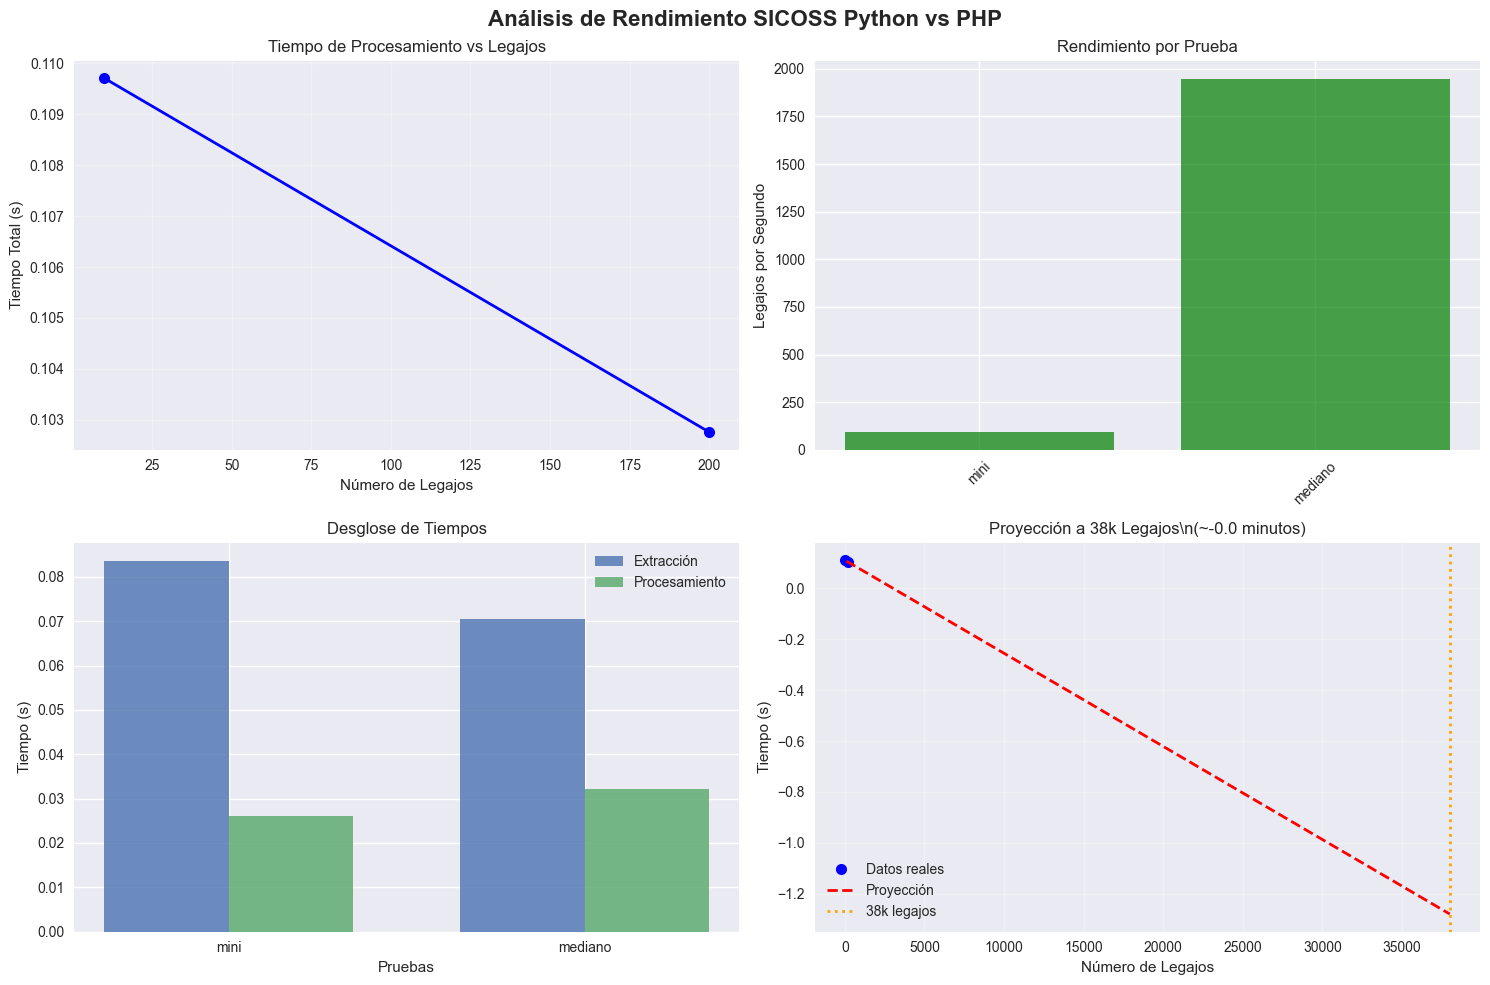

In [13]:
# 📊 VISUALIZACIÓN DE RESULTADOS
# Crear gráficos para analizar los resultados

# Recopilar resultados de todas las pruebas ejecutadas
resultados_pruebas = []

if 'resultado_mini' in locals() and resultado_mini:
    resultados_pruebas.append(resultado_mini)
    
if 'resultado_mediano' in locals() and resultado_mediano:
    resultados_pruebas.append(resultado_mediano)

if resultados_pruebas:
    # Crear DataFrame para análisis
    df_resultados = pd.DataFrame([
        {
            'prueba': r['nombre_prueba'],
            'legajos': r['limite_legajos'],
            'tiempo_extraccion': r['tiempo_extraccion'],
            'tiempo_procesamiento': r['tiempo_procesamiento'],
            'tiempo_total': r['tiempo_total'],
            'legajos_validos': r['estadisticas']['legajos_validos'],
            'rendimiento': r['limite_legajos'] / r['tiempo_total']
        }
        for r in resultados_pruebas
    ])
    
    print("📊 RESUMEN DE PRUEBAS:")
    display(df_resultados)
    
    # Gráficos si tenemos más de una prueba
    if len(resultados_pruebas) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Análisis de Rendimiento SICOSS Python vs PHP', fontsize=16, fontweight='bold')
        
        # Gráfico 1: Tiempo vs Legajos
        axes[0,0].plot(df_resultados['legajos'], df_resultados['tiempo_total'], 'bo-', linewidth=2, markersize=8)
        axes[0,0].set_xlabel('Número de Legajos')
        axes[0,0].set_ylabel('Tiempo Total (s)')
        axes[0,0].set_title('Tiempo de Procesamiento vs Legajos')
        axes[0,0].grid(True, alpha=0.3)
        
        # Gráfico 2: Rendimiento (legajos/segundo)
        axes[0,1].bar(df_resultados['prueba'], df_resultados['rendimiento'], color='green', alpha=0.7)
        axes[0,1].set_ylabel('Legajos por Segundo')
        axes[0,1].set_title('Rendimiento por Prueba')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Gráfico 3: Desglose de tiempos
        width = 0.35
        x = range(len(df_resultados))
        axes[1,0].bar([i - width/2 for i in x], df_resultados['tiempo_extraccion'], width, label='Extracción', alpha=0.8)
        axes[1,0].bar([i + width/2 for i in x], df_resultados['tiempo_procesamiento'], width, label='Procesamiento', alpha=0.8)
        axes[1,0].set_xlabel('Pruebas')
        axes[1,0].set_ylabel('Tiempo (s)')
        axes[1,0].set_title('Desglose de Tiempos')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(df_resultados['prueba'])
        axes[1,0].legend()
        
        # Gráfico 4: Proyección a 38k legajos
        if len(df_resultados) >= 2:
            # Estimar tiempo para 38k legajos usando regresión lineal
            from scipy import stats
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_resultados['legajos'], df_resultados['tiempo_total'])
            
            # Proyección
            legajos_proyeccion = [100, 500, 1000, 5000, 10000, 20000, 38000]
            tiempos_proyeccion = [slope * l + intercept for l in legajos_proyeccion]
            
            axes[1,1].plot(df_resultados['legajos'], df_resultados['tiempo_total'], 'bo', markersize=8, label='Datos reales')
            axes[1,1].plot(legajos_proyeccion, tiempos_proyeccion, 'r--', linewidth=2, label='Proyección')
            axes[1,1].axvline(x=38000, color='orange', linestyle=':', linewidth=2, label='38k legajos')
            axes[1,1].set_xlabel('Número de Legajos')
            axes[1,1].set_ylabel('Tiempo (s)')
            axes[1,1].set_title(f'Proyección a 38k Legajos\\n(~{tiempos_proyeccion[-1]/60:.1f} minutos)')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)
            
            print(f"\\n🔮 PROYECCIÓN PARA 38,000 LEGAJOS:")
            print(f"   Tiempo estimado: {tiempos_proyeccion[-1]:.1f} segundos ({tiempos_proyeccion[-1]/60:.1f} minutos)")
            print(f"   Confianza de la proyección (R²): {r_value**2:.3f}")
        else:
            axes[1,1].text(0.5, 0.5, 'Necesitamos más\ndatos para\nproyección', 
                          ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
            axes[1,1].set_title('Proyección (Datos Insuficientes)')
        
        plt.tight_layout()
        plt.show()
        
else:
    print("⚠️ No hay resultados de pruebas para visualizar")
